In [1]:
# !pip install mesa

In [2]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.time import StagedActivation

from sklearn.cluster import DBSCAN
from itertools import product
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
sns.set_style("darkgrid")

In [3]:
class DeffuantAgent(Agent):
    def __init__(self, unique_id, model, x, u, mu, model_regime='p2p'):
        """
        :param unique_id: int -- ID агента
        :param model: mesa.Model -- Среда для агента
        :param x: float -- Мнение агента
        :param u: float -- Уровень сомнения агента
        :param mu: float -- Константный параметр, описывающий насколько мы восприимчивы к чужому мнению
        :param model_regime: str -- "p2p" или "all" -- режимы работы модели "парный" и "все со всеми"
        """

        super().__init__(unique_id, model)

        self.x = x   # the agent's opinion
        self.u = u   # the agent's level of uncertainty
        self.mu = mu   # the parameter describing susceptibility to others' opinions
        self.delta_x = 0   # the change in opinion for this step
        self.delta_u = 0   # the change in uncertainty for this step
        self.regime = model_regime   # the model mode ("pairwise" or "all-to-all")

    def interaction_p2p(self):
        other_agent = self.model.random.choice(self.model.schedule.agents)   # select a random agent from the model
        overlap = min(self.x + self.u, other_agent.x + other_agent.u) - \
                  max(self.x - self.u, other_agent.x - other_agent.u)   # calculate overlap between opinions

        if overlap > other_agent.u:   # if the overlap is greater than the other agent's uncertainty
            delta_us = overlap / other_agent.u - 1   # calculate delta_us
            self.delta_x = self.mu * delta_us * (other_agent.x - self.x)   # calculate the change in opinion
            self.delta_u = self.mu * delta_us * (other_agent.u - self.u)   # calculate the change in uncertainty

    def interaction_all(self):
        other_agents = [agent for agent in self.model.schedule.agents if agent != self]   # select all agents except self
        for other_agent in other_agents:
            overlap = min(self.x + self.u, other_agent.x + other_agent.u) - \
                      max(self.x - self.u, other_agent.x - other_agent.u)   # calculate overlap between opinions

            if overlap > other_agent.u:   # if the overlap is greater than the other agent's uncertainty
                delta_us = overlap / other_agent.u - 1   # calculate delta_us
                self.delta_x += (self.mu/self.model.num_agents * delta_us * (other_agent.x - self.x))   # calculate the change in opinion
                self.delta_u += (self.mu/self.model.num_agents * delta_us * (other_agent.u - self.u))   # calculate the change in uncertainty

    def step(self):
        self.x += self.delta_x   # update the opinion with the change in opinion
        self.x = max(self.x, -1)   # restrict the opinion within the range [-1, 1]
        self.x = min(self.x, 1)
        self.u += self.delta_u   # update the uncertainty with the change in uncertainty
        self.u = max(self.u, 0.001)   # restrict the uncertainty within the range [0.001, 2]
        self.u = min(self.u, 2)
        self.delta_x = 0   # reset the change in opinion for the next step
        self.delta_u = 0  # reset the change in uncertainty for the next step

In [4]:
class DeffuantModel(Model):
    def __init__(self, n, mu, gen_u, u_e=None, p_e=None, d=None, regime="p2p"):
        """
        :param n: int -- Number of agents
        :param mu: float -- Constant parameter that describes how sensitive we are to other's opinions
        :param gen_u: float -- Uncertainty level of agents
        :param u_e: float -- Uncertainty level of extremists
        :param p_e: float -- The ratio of extremists in the model
        :param d: float -- Ratio of extremists with positive and negative opinions
        :param regime: str -- "p2p" or "all" -- Modes of the model: "pairwise" or "all-to-all"
        """
        super().__init__()

        # Set model variables
        self.num_agents = n
        self.gen_u = gen_u

        # Set variables related to extremists
        self.ext_num = int(p_e * self.num_agents)
        self.u_e = u_e
        self.ext_plus = int((d + 1) * self.ext_num / 2)
        self.ext_minus = self.ext_num - self.ext_plus

        # Set sensitivity parameter and model regime
        self.mu = mu
        self.regime = regime

        # Set stage list and schedule agents' activation
        self.stage_list = ['interaction_' + regime, 'step']
        self.schedule = StagedActivation(model=self, stage_list=self.stage_list, shuffle=False,
                                         shuffle_between_stages=False)

        # Set agents' initial opinions and uncertaincies
        self.opinions = np.random.uniform(-1.01, 1.01, self.num_agents)
        uncertaincies = np.full(self.num_agents, gen_u).astype(float)

        # Set uncertainties of extremists
        extr_ind = np.concatenate([np.argsort(self.opinions)[:self.ext_minus],
                                   np.argsort(self.opinions)[-self.ext_plus:]])
        uncertaincies[extr_ind] = self.u_e
        self.uncertaincies = uncertaincies

        # Create and add agents to the schedule
        for id, (opinion, uncertaincy) in enumerate(zip(self.opinions, self.uncertaincies)):
            a = DeffuantAgent(unique_id=id, model=self, x=opinion, u=uncertaincy, mu=self.mu, model_regime=self.regime)
            self.schedule.add(a)

        # Set up data collection
        self.datacollector = DataCollector(agent_reporters={"Opinion": "x"})

    def step(self):
        # Collect data and execute the agents' actions
        self.datacollector.collect(self)
        self.schedule.step()

In [135]:
RANDOM_STATE = 42
def model(n=100, mu=0.5, gen_u=0.5, u_e=0.05, p_e=0.2, d=0.2,  regime="all", plot=False):
    my_model = DeffuantModel(n=n, mu=mu, gen_u=gen_u, u_e=u_e, p_e=p_e, d=d,  regime=regime)
    my_model.step()
    for i in range(1,300):
        my_model.step()
        norm = np.linalg.norm(my_model.datacollector.get_agent_vars_dataframe().loc[i,:,:].to_numpy() - \
                            my_model.datacollector.get_agent_vars_dataframe().loc[i-1,:,:].to_numpy())
        if norm < 0.0001:
            print('Convergence on {} step'.format(i+2))
            break

    opinions = my_model.datacollector.get_agent_vars_dataframe().reset_index()
    model_final_opinions = opinions[opinions['Step'] == list(opinions['Step'])[-1]].set_index('AgentID').drop(columns='Step')
    
    if plot:
        plt.figure(figsize=(13,9))
        sns.lineplot(data=opinions, x='Step', y='Opinion', hue='AgentID')
    #     plt.savefig(f'PLOT_{regime}_DEFAULT_mu={mu}_gen_u={gen_u}_u_e={u_e}_p_e={p_e}_d={round(d,2)}.png')
        plt.title(f'plot_{regime}_mu={mu}_gen_u={gen_u}_u_e={u_e}_p_e={p_e}_d={d}')
        plt.show()
    #     plt.savefig(f'PLOT_{regime}_DEFAULT_mu={mu}_gen_u={gen_u}_u_e={u_e}_p_e={p_e}_d={round(d,2)}.png')
    
    return model_final_opinions


def cluster_objects(data, dbscan):
    X = np.array(list(data['Opinion'])).reshape(-1, 1)
    dbscan.fit(X)
    data['labels'] = dbscan.labels_
    return data[['Opinion', 'labels']]

def parameters_enum(num_of_agents: int, num_of_tries: int, regime_model, first=False) -> pd.DataFrame: # перебор параметров
    p_e_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    gen_u_list = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6,1.8, 2]
    u_e_list = [0.05, 0.1, 0.15, 0.2]
    d_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    mu_list = [0.1, 0.2, 0.3, 0.4, 0.5]

    columns = ['mu', 'gen_u', 'u_e', 'p_e', 'd', 'num_of_clusters']
    data = {col: [] for col in columns}
    df_final = pd.DataFrame(data, columns=columns) 
    N=100
    EPS = 0.25
    dbscan = DBSCAN(eps=EPS)
    
    t_first = True
    
    params = list(product(mu_list, gen_u_list, u_e_list, p_e_list, d_list))        
        
    
    for mu, gen_u, u_e, p_e, d in tqdm(params):
#         print('do_model')
        df_temp = model(N, mu, gen_u, u_e, p_e, d, regime=regime_model)
#         print('end modl, do_cluster')
        df_temp = cluster_objects(df_temp, dbscan)
        df_temp['num_of_clusters'] = df_temp['labels'].nunique()
        df_temp['mu'] = mu
        df_temp['gen_u'] = gen_u
        df_temp['u_e'] = u_e
        df_temp['p_e'] = p_e
        df_temp['d'] = d
        df_temp['regime_model'] = regime_model
        
        if first and t_first:
            df_temp.to_csv('out.csv')
            t_first = False
        else:
            df_temp.to_csv('out.csv', mode='a', header=False)

def rfr(X, y, n_estimators=100, random_state=RANDOM_STATE):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

#     print(f"Mean Squared Error: {mse:.2f}")
#     print(f"Root Mean Squared Error: {rmse:.2f}")
#     print(f"R^2 Score: {r2:.2f}")

    return mse, rmse, r2, rf_model


def all_project():
    dicts = {}
    first = True
    for i in ['all', 'p2p']:
        d = {}
#         print('start enumerating')
        parameters_enum(num_of_agents=100, num_of_tries=10, regime_model = i, first=first)
        first= False
        data = pd.read_csv('out.csv', index_col=0)
        data = data.drop(columns=['Opinion', 'labels']).drop_duplicates()
#         print('end enumerating')
        X, y_true = data.drop(columns=['num_of_clusters', 'regime_model']), data[['num_of_clusters']]
        mse, rmse, r2, rf_model = rfr(X, y_true)
        d['mse'] = mse
        d['rmse'] = rmse
        d['r2'] = r2
        d['rf_model'] = rf_model
        dicts[i] = d
    return dicts

In [124]:
%%time
t = model(regime='all')

Convergence on 195 step
CPU times: user 3.25 s, sys: 4.1 ms, total: 3.25 s
Wall time: 3.25 s


start model steps


  0%|          | 0/299 [00:00<?, ?it/s]

Convergence on 298 step


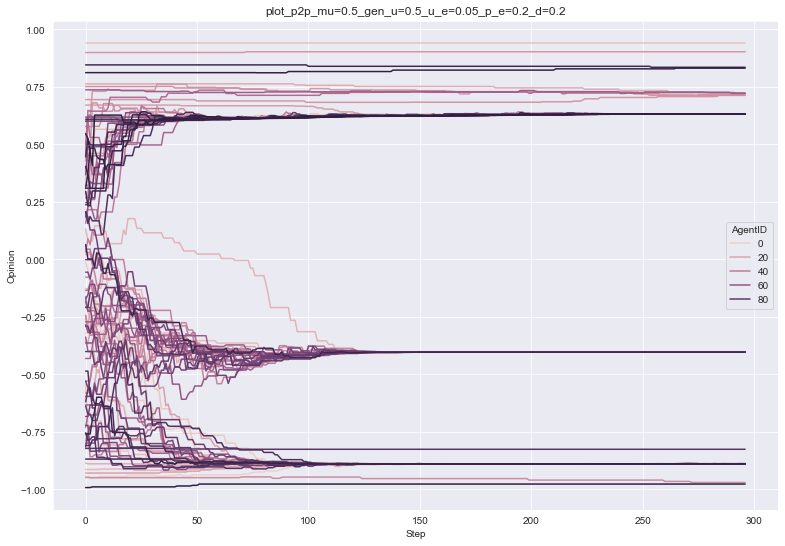

CPU times: user 12.3 s, sys: 363 ms, total: 12.7 s
Wall time: 13.7 s


In [9]:
%%time
t = model(regime='p2p')

In [136]:
%%time
final_result = all_project()
final_result

  0%|          | 0/7200 [00:00<?, ?it/s]

Convergence on 298 step
Convergence on 228 step
Convergence on 236 step
Convergence on 198 step
Convergence on 208 step
Convergence on 241 step
Convergence on 298 step
Convergence on 295 step
Convergence on 197 step
Convergence on 156 step
Convergence on 148 step
Convergence on 166 step
Convergence on 156 step
Convergence on 157 step
Convergence on 150 step
Convergence on 163 step
Convergence on 141 step
Convergence on 256 step
Convergence on 231 step
Convergence on 149 step
Convergence on 166 step
Convergence on 145 step
Convergence on 165 step
Convergence on 155 step
Convergence on 172 step
Convergence on 160 step
Convergence on 156 step
Convergence on 146 step
Convergence on 301 step
Convergence on 273 step
Convergence on 273 step
Convergence on 150 step
Convergence on 141 step
Convergence on 152 step
Convergence on 186 step
Convergence on 223 step
Convergence on 252 step
Convergence on 261 step
Convergence on 295 step
Convergence on 282 step
Convergence on 296 step
Convergence on 2

Convergence on 271 step
Convergence on 237 step
Convergence on 202 step
Convergence on 231 step
Convergence on 291 step
Convergence on 178 step
Convergence on 283 step
Convergence on 282 step
Convergence on 288 step
Convergence on 265 step
Convergence on 299 step
Convergence on 212 step
Convergence on 266 step
Convergence on 263 step
Convergence on 235 step
Convergence on 238 step
Convergence on 191 step
Convergence on 224 step
Convergence on 264 step
Convergence on 269 step
Convergence on 228 step
Convergence on 230 step
Convergence on 205 step
Convergence on 258 step
Convergence on 221 step
Convergence on 251 step
Convergence on 219 step
Convergence on 297 step
Convergence on 217 step
Convergence on 230 step
Convergence on 157 step
Convergence on 129 step
Convergence on 294 step
Convergence on 267 step
Convergence on 283 step
Convergence on 242 step
Convergence on 259 step
Convergence on 266 step
Convergence on 232 step
Convergence on 254 step
Convergence on 210 step
Convergence on 2

Convergence on 134 step
Convergence on 181 step
Convergence on 152 step
Convergence on 201 step
Convergence on 150 step
Convergence on 270 step
Convergence on 186 step
Convergence on 123 step
Convergence on 142 step
Convergence on 143 step
Convergence on 186 step
Convergence on 161 step
Convergence on 166 step
Convergence on 135 step
Convergence on 139 step
Convergence on 148 step
Convergence on 212 step
Convergence on 109 step
Convergence on 288 step
Convergence on 153 step
Convergence on 266 step
Convergence on 239 step
Convergence on 75 step
Convergence on 247 step
Convergence on 266 step
Convergence on 241 step
Convergence on 229 step
Convergence on 264 step
Convergence on 253 step
Convergence on 228 step
Convergence on 193 step
Convergence on 247 step
Convergence on 235 step
Convergence on 275 step
Convergence on 227 step
Convergence on 150 step
Convergence on 245 step
Convergence on 203 step
Convergence on 202 step
Convergence on 221 step
Convergence on 249 step
Convergence on 25

Convergence on 231 step
Convergence on 217 step
Convergence on 160 step
Convergence on 240 step
Convergence on 264 step
Convergence on 181 step
Convergence on 294 step
Convergence on 205 step
Convergence on 178 step
Convergence on 148 step
Convergence on 147 step
Convergence on 204 step
Convergence on 186 step
Convergence on 138 step
Convergence on 174 step
Convergence on 193 step
Convergence on 125 step
Convergence on 195 step
Convergence on 206 step
Convergence on 167 step
Convergence on 221 step
Convergence on 192 step
Convergence on 301 step
Convergence on 245 step
Convergence on 190 step
Convergence on 218 step
Convergence on 165 step
Convergence on 289 step
Convergence on 238 step
Convergence on 228 step
Convergence on 253 step
Convergence on 262 step
Convergence on 300 step
Convergence on 216 step
Convergence on 192 step
Convergence on 178 step
Convergence on 162 step
Convergence on 159 step
Convergence on 248 step
Convergence on 263 step
Convergence on 161 step
Convergence on 1

Convergence on 285 step
Convergence on 210 step
Convergence on 215 step
Convergence on 248 step
Convergence on 217 step
Convergence on 222 step
Convergence on 266 step
Convergence on 233 step
Convergence on 214 step
Convergence on 216 step
Convergence on 247 step
Convergence on 222 step
Convergence on 231 step
Convergence on 210 step
Convergence on 242 step
Convergence on 238 step
Convergence on 247 step
Convergence on 195 step
Convergence on 244 step
Convergence on 295 step
Convergence on 153 step
Convergence on 194 step
Convergence on 238 step
Convergence on 223 step
Convergence on 194 step
Convergence on 193 step
Convergence on 294 step
Convergence on 187 step
Convergence on 195 step
Convergence on 184 step
Convergence on 206 step
Convergence on 164 step
Convergence on 291 step
Convergence on 281 step
Convergence on 180 step
Convergence on 261 step
Convergence on 237 step
Convergence on 223 step
Convergence on 242 step
Convergence on 173 step
Convergence on 216 step
Convergence on 2

Convergence on 186 step
Convergence on 176 step
Convergence on 140 step
Convergence on 138 step
Convergence on 105 step
Convergence on 110 step
Convergence on 151 step
Convergence on 158 step
Convergence on 200 step
Convergence on 118 step
Convergence on 105 step
Convergence on 107 step
Convergence on 246 step
Convergence on 117 step
Convergence on 120 step
Convergence on 135 step
Convergence on 157 step
Convergence on 106 step
Convergence on 130 step
Convergence on 95 step
Convergence on 101 step
Convergence on 164 step
Convergence on 106 step
Convergence on 193 step
Convergence on 285 step
Convergence on 127 step
Convergence on 212 step
Convergence on 106 step
Convergence on 209 step
Convergence on 216 step
Convergence on 166 step
Convergence on 110 step
Convergence on 153 step
Convergence on 118 step
Convergence on 141 step
Convergence on 132 step
Convergence on 166 step
Convergence on 139 step
Convergence on 93 step
Convergence on 101 step
Convergence on 120 step
Convergence on 129

Convergence on 133 step
Convergence on 236 step
Convergence on 161 step
Convergence on 281 step
Convergence on 104 step
Convergence on 179 step
Convergence on 196 step
Convergence on 169 step
Convergence on 295 step
Convergence on 191 step
Convergence on 177 step
Convergence on 201 step
Convergence on 192 step
Convergence on 134 step
Convergence on 191 step
Convergence on 146 step
Convergence on 132 step
Convergence on 235 step
Convergence on 151 step
Convergence on 120 step
Convergence on 271 step
Convergence on 164 step
Convergence on 185 step
Convergence on 162 step
Convergence on 191 step
Convergence on 167 step
Convergence on 240 step
Convergence on 205 step
Convergence on 185 step
Convergence on 209 step
Convergence on 230 step
Convergence on 174 step
Convergence on 190 step
Convergence on 213 step
Convergence on 199 step
Convergence on 159 step
Convergence on 116 step
Convergence on 171 step
Convergence on 153 step
Convergence on 168 step
Convergence on 177 step
Convergence on 1

Convergence on 234 step
Convergence on 217 step
Convergence on 218 step
Convergence on 219 step
Convergence on 219 step
Convergence on 217 step
Convergence on 169 step
Convergence on 143 step
Convergence on 128 step
Convergence on 137 step
Convergence on 152 step
Convergence on 111 step
Convergence on 189 step
Convergence on 258 step
Convergence on 123 step
Convergence on 185 step
Convergence on 171 step
Convergence on 171 step
Convergence on 148 step
Convergence on 140 step
Convergence on 144 step
Convergence on 272 step
Convergence on 158 step
Convergence on 138 step
Convergence on 110 step
Convergence on 147 step
Convergence on 174 step
Convergence on 166 step
Convergence on 173 step
Convergence on 190 step
Convergence on 235 step
Convergence on 147 step
Convergence on 192 step
Convergence on 142 step
Convergence on 158 step
Convergence on 193 step
Convergence on 191 step
Convergence on 192 step
Convergence on 207 step
Convergence on 192 step
Convergence on 192 step
Convergence on 1

Convergence on 233 step
Convergence on 122 step
Convergence on 149 step
Convergence on 112 step
Convergence on 129 step
Convergence on 220 step
Convergence on 210 step
Convergence on 178 step
Convergence on 160 step
Convergence on 189 step
Convergence on 217 step
Convergence on 168 step
Convergence on 187 step
Convergence on 210 step
Convergence on 288 step
Convergence on 211 step
Convergence on 215 step
Convergence on 229 step
Convergence on 164 step
Convergence on 149 step
Convergence on 160 step
Convergence on 170 step
Convergence on 112 step
Convergence on 152 step
Convergence on 163 step
Convergence on 126 step
Convergence on 140 step
Convergence on 284 step
Convergence on 100 step
Convergence on 105 step
Convergence on 181 step
Convergence on 81 step
Convergence on 289 step
Convergence on 240 step
Convergence on 227 step
Convergence on 239 step
Convergence on 97 step
Convergence on 191 step
Convergence on 138 step
Convergence on 135 step
Convergence on 123 step
Convergence on 100

Convergence on 266 step
Convergence on 131 step
Convergence on 245 step
Convergence on 152 step
Convergence on 131 step
Convergence on 213 step
Convergence on 248 step
Convergence on 248 step
Convergence on 238 step
Convergence on 155 step
Convergence on 221 step
Convergence on 257 step
Convergence on 264 step
Convergence on 229 step
Convergence on 256 step
Convergence on 286 step
Convergence on 266 step
Convergence on 262 step
Convergence on 183 step
Convergence on 260 step
Convergence on 182 step
Convergence on 188 step
Convergence on 183 step
Convergence on 183 step
Convergence on 201 step
Convergence on 286 step
Convergence on 123 step
Convergence on 167 step
Convergence on 103 step
Convergence on 94 step
Convergence on 237 step
Convergence on 107 step
Convergence on 136 step
Convergence on 200 step
Convergence on 196 step
Convergence on 173 step
Convergence on 288 step
Convergence on 188 step
Convergence on 141 step
Convergence on 222 step
Convergence on 164 step
Convergence on 19

Convergence on 160 step
Convergence on 86 step
Convergence on 83 step
Convergence on 82 step
Convergence on 76 step
Convergence on 154 step
Convergence on 152 step
Convergence on 133 step
Convergence on 159 step
Convergence on 121 step
Convergence on 91 step
Convergence on 113 step
Convergence on 94 step
Convergence on 88 step
Convergence on 112 step
Convergence on 121 step
Convergence on 139 step
Convergence on 98 step
Convergence on 133 step
Convergence on 122 step
Convergence on 78 step
Convergence on 150 step
Convergence on 110 step
Convergence on 129 step
Convergence on 130 step
Convergence on 112 step
Convergence on 119 step
Convergence on 104 step
Convergence on 244 step
Convergence on 243 step
Convergence on 244 step
Convergence on 243 step
Convergence on 246 step
Convergence on 192 step
Convergence on 287 step
Convergence on 244 step
Convergence on 156 step
Convergence on 116 step
Convergence on 281 step
Convergence on 262 step
Convergence on 254 step
Convergence on 230 step
C

/tmp/ipykernel_5194/428482882.py:74: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


  0%|          | 0/7200 [00:00<?, ?it/s]

Convergence on 224 step
Convergence on 295 step
Convergence on 274 step
Convergence on 252 step
Convergence on 281 step
Convergence on 295 step
Convergence on 300 step
Convergence on 289 step
Convergence on 268 step
Convergence on 172 step
Convergence on 161 step
Convergence on 213 step
Convergence on 265 step
Convergence on 274 step
Convergence on 219 step
Convergence on 197 step
Convergence on 207 step
Convergence on 207 step
Convergence on 195 step
Convergence on 179 step
Convergence on 163 step
Convergence on 196 step
Convergence on 184 step
Convergence on 189 step
Convergence on 281 step
Convergence on 279 step
Convergence on 167 step
Convergence on 235 step
Convergence on 247 step
Convergence on 179 step
Convergence on 233 step
Convergence on 276 step
Convergence on 278 step
Convergence on 286 step
Convergence on 171 step
Convergence on 186 step
Convergence on 232 step
Convergence on 250 step
Convergence on 221 step
Convergence on 300 step
Convergence on 255 step
Convergence on 2

Convergence on 188 step
Convergence on 203 step
Convergence on 180 step
Convergence on 182 step
Convergence on 95 step
Convergence on 263 step
Convergence on 131 step
Convergence on 283 step
Convergence on 280 step
Convergence on 195 step
Convergence on 188 step
Convergence on 222 step
Convergence on 217 step
Convergence on 230 step
Convergence on 167 step
Convergence on 252 step
Convergence on 172 step
Convergence on 172 step
Convergence on 168 step
Convergence on 226 step
Convergence on 169 step
Convergence on 177 step
Convergence on 173 step
Convergence on 190 step
Convergence on 225 step
Convergence on 202 step
Convergence on 173 step
Convergence on 151 step
Convergence on 150 step
Convergence on 186 step
Convergence on 205 step
Convergence on 186 step
Convergence on 229 step
Convergence on 243 step
Convergence on 257 step
Convergence on 230 step
Convergence on 272 step
Convergence on 270 step
Convergence on 234 step
Convergence on 211 step
Convergence on 280 step
Convergence on 17

Convergence on 239 step
Convergence on 267 step
Convergence on 205 step
Convergence on 214 step
Convergence on 168 step
Convergence on 156 step
Convergence on 166 step
Convergence on 249 step
Convergence on 192 step
Convergence on 235 step
Convergence on 159 step
Convergence on 203 step
Convergence on 297 step
Convergence on 170 step
Convergence on 156 step
Convergence on 145 step
Convergence on 241 step
Convergence on 296 step
Convergence on 262 step
Convergence on 213 step
Convergence on 232 step
Convergence on 203 step
Convergence on 195 step
Convergence on 109 step
Convergence on 179 step
Convergence on 167 step
Convergence on 210 step
Convergence on 159 step
Convergence on 291 step
Convergence on 163 step
Convergence on 138 step
Convergence on 141 step
Convergence on 257 step
Convergence on 252 step
Convergence on 171 step
Convergence on 164 step
Convergence on 140 step
Convergence on 230 step
Convergence on 226 step
Convergence on 222 step
Convergence on 138 step
Convergence on 1

Convergence on 154 step
Convergence on 194 step
Convergence on 238 step
Convergence on 170 step
Convergence on 155 step
Convergence on 254 step
Convergence on 194 step
Convergence on 187 step
Convergence on 180 step
Convergence on 199 step
Convergence on 250 step
Convergence on 183 step
Convergence on 178 step
Convergence on 147 step
Convergence on 211 step
Convergence on 197 step
Convergence on 193 step
Convergence on 217 step
Convergence on 186 step
Convergence on 298 step
Convergence on 216 step
Convergence on 163 step
Convergence on 137 step
Convergence on 180 step
Convergence on 127 step
Convergence on 147 step
Convergence on 223 step
Convergence on 182 step
Convergence on 103 step
Convergence on 172 step
Convergence on 128 step
Convergence on 151 step
Convergence on 150 step
Convergence on 139 step
Convergence on 175 step
Convergence on 134 step
Convergence on 153 step
Convergence on 149 step
Convergence on 206 step
Convergence on 261 step
Convergence on 183 step
Convergence on 2

Convergence on 130 step
Convergence on 186 step
Convergence on 260 step
Convergence on 134 step
Convergence on 106 step
Convergence on 142 step
Convergence on 147 step
Convergence on 234 step
Convergence on 144 step
Convergence on 101 step
Convergence on 190 step
Convergence on 126 step
Convergence on 129 step
Convergence on 123 step
Convergence on 207 step
Convergence on 146 step
Convergence on 211 step
Convergence on 149 step
Convergence on 156 step
Convergence on 137 step
Convergence on 148 step
Convergence on 146 step
Convergence on 117 step
Convergence on 114 step
Convergence on 140 step
Convergence on 199 step
Convergence on 156 step
Convergence on 274 step
Convergence on 267 step
Convergence on 273 step
Convergence on 247 step
Convergence on 248 step
Convergence on 249 step
Convergence on 167 step
Convergence on 138 step
Convergence on 187 step
Convergence on 280 step
Convergence on 254 step
Convergence on 294 step
Convergence on 180 step
Convergence on 203 step
Convergence on 1

Convergence on 154 step
Convergence on 114 step
Convergence on 111 step
Convergence on 107 step
Convergence on 116 step
Convergence on 137 step
Convergence on 129 step
Convergence on 122 step
Convergence on 120 step
Convergence on 84 step
Convergence on 136 step
Convergence on 134 step
Convergence on 170 step
Convergence on 92 step
Convergence on 155 step
Convergence on 107 step
Convergence on 157 step
Convergence on 127 step
Convergence on 201 step
Convergence on 115 step
Convergence on 184 step
Convergence on 84 step
Convergence on 119 step
Convergence on 117 step
Convergence on 125 step
Convergence on 144 step
Convergence on 156 step
Convergence on 111 step
Convergence on 275 step
Convergence on 278 step
Convergence on 301 step
Convergence on 122 step
Convergence on 197 step
Convergence on 282 step
Convergence on 234 step
Convergence on 129 step
Convergence on 183 step
Convergence on 228 step
Convergence on 149 step
Convergence on 248 step
Convergence on 118 step
Convergence on 214 

Convergence on 213 step
Convergence on 184 step
Convergence on 137 step
Convergence on 164 step
Convergence on 165 step
Convergence on 184 step
Convergence on 152 step
Convergence on 180 step
Convergence on 181 step
Convergence on 174 step
Convergence on 155 step
Convergence on 207 step
Convergence on 171 step
Convergence on 181 step
Convergence on 162 step
Convergence on 263 step
Convergence on 187 step
Convergence on 186 step
Convergence on 162 step
Convergence on 271 step
Convergence on 195 step
Convergence on 158 step
Convergence on 200 step
Convergence on 201 step
Convergence on 237 step
Convergence on 159 step
Convergence on 224 step
Convergence on 161 step
Convergence on 197 step
Convergence on 204 step
Convergence on 164 step
Convergence on 301 step
Convergence on 190 step
Convergence on 192 step
Convergence on 174 step
Convergence on 241 step
Convergence on 177 step
Convergence on 156 step
Convergence on 207 step
Convergence on 192 step
Convergence on 153 step
Convergence on 1

Convergence on 187 step
Convergence on 124 step
Convergence on 207 step
Convergence on 253 step
Convergence on 251 step
Convergence on 155 step
Convergence on 185 step
Convergence on 102 step
Convergence on 117 step
Convergence on 204 step
Convergence on 105 step
Convergence on 185 step
Convergence on 222 step
Convergence on 158 step
Convergence on 100 step
Convergence on 130 step
Convergence on 143 step
Convergence on 128 step
Convergence on 122 step
Convergence on 195 step
Convergence on 138 step
Convergence on 210 step
Convergence on 198 step
Convergence on 155 step
Convergence on 119 step
Convergence on 154 step
Convergence on 200 step
Convergence on 198 step
Convergence on 197 step
Convergence on 225 step
Convergence on 234 step
Convergence on 187 step
Convergence on 192 step
Convergence on 128 step
Convergence on 126 step
Convergence on 129 step
Convergence on 129 step
Convergence on 150 step
Convergence on 132 step
Convergence on 106 step
Convergence on 161 step
Convergence on 1

Convergence on 165 step
Convergence on 101 step
Convergence on 166 step
Convergence on 120 step
Convergence on 132 step
Convergence on 67 step
Convergence on 144 step
Convergence on 160 step
Convergence on 87 step
Convergence on 107 step
Convergence on 98 step
Convergence on 114 step
Convergence on 121 step
Convergence on 181 step
Convergence on 116 step
Convergence on 106 step
Convergence on 92 step
Convergence on 102 step
Convergence on 125 step
Convergence on 110 step
Convergence on 168 step
Convergence on 162 step
Convergence on 298 step
Convergence on 158 step
Convergence on 182 step
Convergence on 172 step
Convergence on 160 step
Convergence on 183 step
Convergence on 255 step
Convergence on 180 step
Convergence on 147 step
Convergence on 101 step
Convergence on 189 step
Convergence on 116 step
Convergence on 202 step
Convergence on 131 step
Convergence on 218 step
Convergence on 186 step
Convergence on 222 step
Convergence on 239 step
Convergence on 237 step
Convergence on 155 s

Convergence on 168 step
Convergence on 108 step
Convergence on 209 step
Convergence on 193 step
Convergence on 219 step
Convergence on 164 step
Convergence on 265 step
Convergence on 145 step
Convergence on 121 step
Convergence on 153 step
Convergence on 281 step
Convergence on 141 step
Convergence on 126 step
Convergence on 119 step
Convergence on 94 step
Convergence on 142 step
Convergence on 120 step
Convergence on 83 step
Convergence on 77 step
Convergence on 74 step
Convergence on 124 step
Convergence on 117 step
Convergence on 158 step
Convergence on 147 step
Convergence on 73 step
Convergence on 64 step
Convergence on 142 step
Convergence on 94 step
Convergence on 94 step
Convergence on 144 step
Convergence on 146 step
Convergence on 69 step
Convergence on 99 step
Convergence on 102 step
Convergence on 110 step
Convergence on 110 step
Convergence on 132 step
Convergence on 200 step
Convergence on 120 step
Convergence on 123 step
Convergence on 175 step
Convergence on 201 step
Co

Convergence on 206 step
Convergence on 127 step
Convergence on 183 step
Convergence on 254 step
Convergence on 116 step
Convergence on 215 step
Convergence on 258 step
Convergence on 127 step
Convergence on 283 step
Convergence on 139 step
Convergence on 157 step
Convergence on 180 step
Convergence on 152 step
Convergence on 130 step
Convergence on 138 step
Convergence on 248 step
Convergence on 144 step
Convergence on 122 step
Convergence on 126 step
Convergence on 145 step
Convergence on 195 step
Convergence on 152 step
Convergence on 258 step
Convergence on 161 step
Convergence on 121 step
Convergence on 110 step
Convergence on 141 step
Convergence on 151 step
Convergence on 118 step
Convergence on 125 step
Convergence on 263 step
Convergence on 273 step
Convergence on 205 step
Convergence on 116 step
Convergence on 120 step
Convergence on 166 step
Convergence on 146 step
Convergence on 138 step
Convergence on 110 step
Convergence on 120 step
Convergence on 119 step
Convergence on 1

Convergence on 287 step
Convergence on 123 step
Convergence on 136 step
Convergence on 122 step
Convergence on 140 step
Convergence on 141 step
Convergence on 147 step
Convergence on 105 step
Convergence on 85 step
Convergence on 104 step
Convergence on 113 step
Convergence on 93 step
Convergence on 111 step
Convergence on 87 step
Convergence on 100 step
Convergence on 120 step
Convergence on 89 step
Convergence on 107 step
Convergence on 95 step
Convergence on 98 step
Convergence on 110 step
Convergence on 108 step
Convergence on 99 step
Convergence on 153 step
Convergence on 83 step
Convergence on 176 step
Convergence on 80 step
Convergence on 98 step
Convergence on 79 step
Convergence on 88 step
Convergence on 93 step
Convergence on 92 step
Convergence on 75 step
Convergence on 218 step
Convergence on 85 step
Convergence on 106 step
Convergence on 163 step
Convergence on 195 step
Convergence on 161 step
Convergence on 123 step
Convergence on 190 step
Convergence on 99 step
Convergen

Convergence on 122 step
Convergence on 122 step
Convergence on 90 step
Convergence on 86 step
Convergence on 85 step
Convergence on 186 step
Convergence on 96 step
Convergence on 103 step
Convergence on 128 step
Convergence on 142 step
Convergence on 162 step
Convergence on 113 step
Convergence on 121 step
Convergence on 117 step
Convergence on 143 step
Convergence on 120 step
Convergence on 153 step
Convergence on 110 step
Convergence on 277 step
Convergence on 101 step
Convergence on 107 step
Convergence on 157 step
Convergence on 114 step
Convergence on 171 step
Convergence on 111 step
Convergence on 143 step
Convergence on 92 step
Convergence on 140 step
Convergence on 111 step
Convergence on 87 step
Convergence on 221 step
Convergence on 95 step
Convergence on 91 step
Convergence on 94 step
Convergence on 119 step
Convergence on 104 step
Convergence on 93 step
Convergence on 90 step
Convergence on 81 step
Convergence on 65 step
Convergence on 110 step
Convergence on 92 step
Conver

Convergence on 98 step
Convergence on 121 step
Convergence on 119 step
Convergence on 112 step
Convergence on 108 step
Convergence on 131 step
Convergence on 94 step
Convergence on 83 step
Convergence on 109 step
Convergence on 138 step
Convergence on 153 step
Convergence on 143 step
Convergence on 85 step
Convergence on 107 step
Convergence on 103 step
Convergence on 89 step
Convergence on 273 step
Convergence on 69 step
Convergence on 71 step
Convergence on 93 step
Convergence on 120 step
Convergence on 125 step
Convergence on 85 step
Convergence on 121 step


/tmp/ipykernel_5194/428482882.py:74: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


CPU times: user 15h 21min 17s, sys: 11.3 s, total: 15h 21min 28s
Wall time: 15h 22min 16s


{'all': {'mse': 0.23103368055555554,
  'rmse': 0.48065963066972406,
  'r2': 0.7534646482943739,
  'rf_model': RandomForestRegressor(random_state=42)},
 'p2p': {'mse': 0.2754196195152978,
  'rmse': 0.5248043630871392,
  'r2': 0.7186812818976034,
  'rf_model': RandomForestRegressor(random_state=42)}}

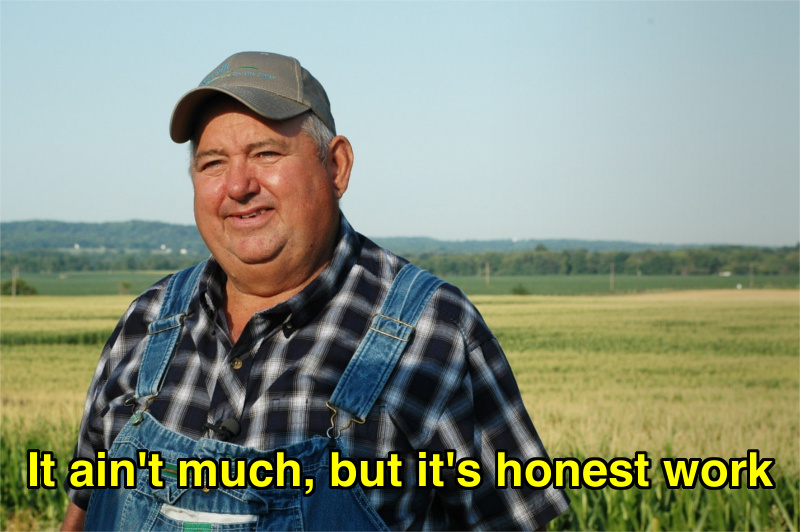

In [3]:
see_result = pd.read_csv('out.csv', index_col=0)
see_result

,Opinion,labels,num_of_clusters,mu,gen_u,u_e,p_e,d,regime_model
AgentID,,,,,,,,,
0,0.492532,0,2,0.1,0.2,0.05,0.05,0.0,all
1,-0.650375,1,2,0.1,0.2,0.05,0.05,0.0,all
2,1.000000,0,2,0.1,0.2,0.05,0.05,0.0,all
3,0.039605,0,2,0.1,0.2,0.05,0.05,0.0,all
4,0.925936,0,2,0.1,0.2,0.05,0.05,0.0,all
...,...,...,...,...,...,...,...,...,...
95,-0.872059,1,2,0.5,2.0,0.20,0.30,0.5,p2p
96,-0.871952,1,2,0.5,2.0,0.20,0.30,0.5,p2p
97,0.689215,0,2,0.5,2.0,0.20,0.30,0.5,p2p


In [5]:
result = {
    'all': {
        'mse': 0.23103368055555554,
        'rmse': 0.48065963066972406,
        'r2': 0.7534646482943739,
        'rf_model': RandomForestRegressor(random_state=42)
    },
    'p2p': {
        'mse': 0.2754196195152978,
        'rmse': 0.5248043630871392,
        'r2': 0.7186812818976034,
        'rf_model': RandomForestRegressor(random_state=42)
    }
}

In [17]:
res_all = pd.DataFrame.from_dict(result['all'], orient='index', columns=['all']).T
res_p2p= pd.DataFrame.from_dict(result['p2p'], orient='index', columns=['p2p']).T
pd.concat([res_all, res_p2p])

,mse,rmse,r2,rf_model
all,0.231034,0.48066,0.753465,RandomForestRegressor(random_state=42)
p2p,0.27542,0.524804,0.718681,RandomForestRegressor(random_state=42)
